#imports

In [1]:
import numpy as np
%matplotlib inline
import os,random
import keras.models as models
import matplotlib.pyplot as plt
import _pickle as cPickle
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,Reshape,Dropout,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras import metrics
from pandas import DataFrame as df
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Get Data

In [ ]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!mv 'RML2016.10b.tar.bz2' '../content/drive/MyDrive/DM_4/Data/'
!bunzip2 '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar.bz2' 

#load data

In [ ]:
!tar -xf '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar'
!mv 'RML2016.10b.dat' '../content/drive/MyDrive/DM_4/Data/'
!mv 'LICENSE.TXT' '../content/drive/MyDrive/DM_4/Data/'

In [2]:
# Load the dataset
file = open("../content/drive/MyDrive/DM_4/Data/RML2016.10b.dat",'rb')
Xd = cPickle.load(file, encoding = 'latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()


In [ ]:
print(X.shape)
X.shape[1:]

(1200000, 2, 128)


(2, 128)

In [3]:
#input shape is (2, 128)
in_shp = list(X.shape[1:])

# num exist classes
classes = mods
print(mods, len(mods))

#first feature
print( X[:,0].shape)
#second feature
print( X[:,1].shape)

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] 10
(1200000, 128)
(1200000, 128)


#Create Features Space

In [4]:
features = {}

#Raw Time Feature
features['raw'] = X[:,0], X[:,1]

#First derivative in time
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

#Integral in time
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

#combinations of 1,2 and 3
def extract_features(*arguments):
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    return np.stack(desired, axis = 1)

#Split data into training/validation and testing
    ○ Split the data into 70% for training/validation and 30% for testing.
    ○ Use 5% of the training and validation dataset for validation.


In [5]:
#choose features
#data = extract_features('raw','integral')
data = extract_features('integral')
labels = np.array(lbl)
print("data shape ", data.shape)
print("labels shape ", labels.shape)
print("data ", data)
print("labels ", labels)

#data shuffling & splitting
np.random.seed(10)
n_examples = labels.shape[0]
r = np.random.choice(range(n_examples), n_examples, replace = False)

num_training = n_examples*0.7
train_examples = r[:int(num_training)]
test_examples =  r[int(num_training):]
print("train_examples ", len(train_examples))
print("test_examples ", len(test_examples))

X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


data shape  (1200000, 2, 128)
labels shape  (1200000, 2)
data  [[[ 0.01147853  0.01906481  0.01455302 ...  0.15236448  0.15129553
    0.15633103]
  [-0.00155472  0.02141102  0.04002929 ... -0.02201433 -0.0440998
   -0.06626738]]

 [[-0.00615713 -0.02160878 -0.03158464 ... -0.14844999 -0.1523091
   -0.15993154]
  [ 0.01931132 -0.00154867  0.0006402  ...  0.13048658  0.12792528
    0.14005409]]

 [[ 0.00813042 -0.03108993 -0.02423892 ... -0.08297462 -0.05955883
    0.04064029]
  [-0.00561907 -0.02465524 -0.02870776 ... -0.05373027 -0.05503425
   -0.03691867]]

 ...

 [[ 0.00119853  0.00236474  0.00350384 ...  0.15040502  0.1516301
    0.15285832]
  [-0.00118417 -0.00237157 -0.0035654  ... -0.14976272 -0.1509522
   -0.15213236]]

 [[ 0.00118075  0.0023467   0.00353525 ...  0.15025946  0.15145004
    0.15263286]
  [-0.00119586 -0.00239046 -0.0035921  ... -0.14965747 -0.15083422
   -0.15201257]]

 [[ 0.0011848   0.00236868  0.00356431 ...  0.14995949  0.15116388
    0.15236188]
  [-0.001185

#Model fully connected dense layer

In [ ]:
def full_connected_model(in_shape):
  # Declare layers size
  hidden1_size = 512
  hidden2_size = 256
  hidden3_size = 10

  # Build model
  model = Sequential()
  model.add(Dense(hidden1_size, input_shape = in_shape, activation ='relu'))
  model.add(Dense(hidden2_size, activation ='relu'))
  model.add(Flatten())
  model.add(Dense(hidden3_size, activation ='softmax'))

  # Compile model
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
  model.summary()
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 512)            66048     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 5s 7ms/step - loss: 2.0804 - accuracy: 0.1935 - val_loss: 1.9248 - val_accuracy: 0.2407

Epoch 00001: val_accuracy improved from -inf to 0.24067, saving model to ../content/drive/MyDrive/DM_4/f

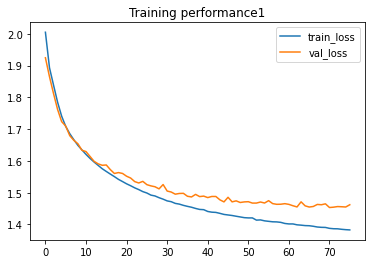

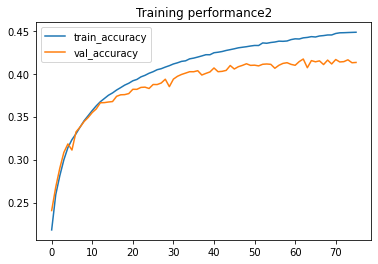

In [ ]:
def train_full_connected_model(X_train, y_train, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  # this is both on training and validation data, hence two curves. They track well.
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_full_connected_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_integral.h5', 100)


#Test of fully connected

In [ ]:
def test_full_connected_model(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_full_connected_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_integral.h5', 100)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_4 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[1.4496387243270874, 0.41671112179756165]


#Plots of the accuracy against the SNR 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 512)            66048     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


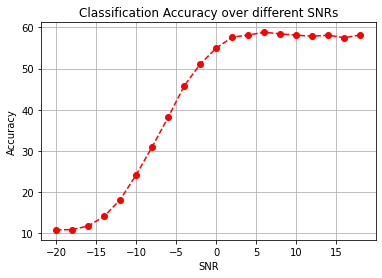

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_integral.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_integral.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_integral.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_integral.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_4 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.85,10.93,11.79,14.13,18.17,24.19,31.01,38.17,45.81,51.08,54.98,57.63,58.14,58.82,58.41,58.1,57.86,58.09,57.49,58.17


#confusion matrices and find the most confusing classes

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[[0.17895676 0.03844545 0.12225041 0.0700605  0.0654883  0.1364967
  0.10267919 0.14828961 0.11854247 0.0187906 ]
 [0.02572846 0.70187696 0.04818542 0.02467493 0.04593973 0.01649616
  0.00504588 0.00177438 0.0116998  0.11857828]
 [0.06559523 0.04

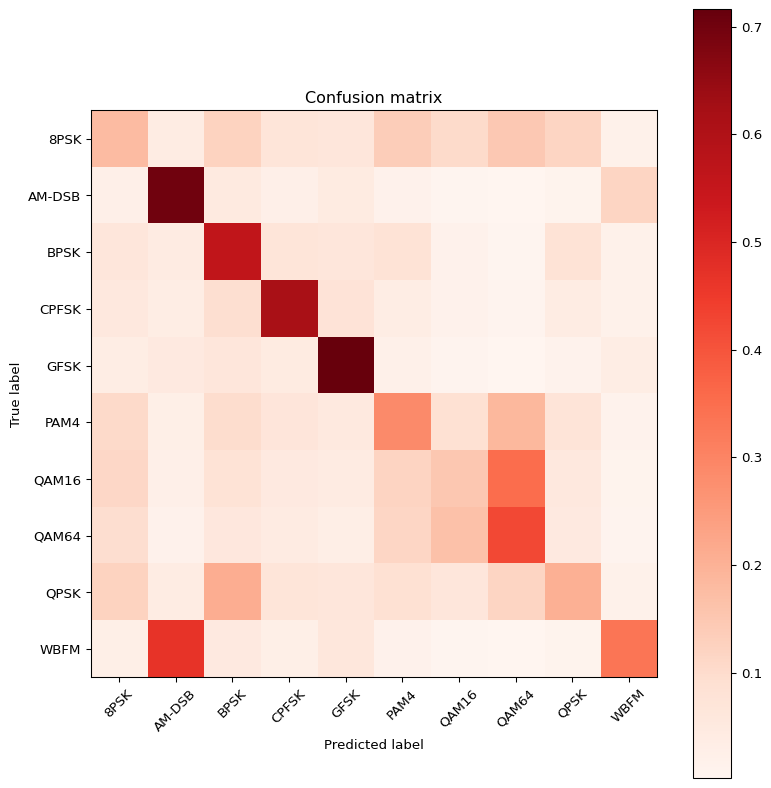

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_integral.h5', 100)


#Model CNN

In [ ]:
def cnn_model(in_shape):
  conv1_kernel_shape=(3,1)
  conv1_number_of_filters=64
  conv2_kernel_shape=(3,2)
  conv2_number_of_filters=16
  dense1_size = 128
  dense2_size = 10
  dropout = 0.4

  # Build model
  model_conv = Sequential()
  model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
  model_conv.add(Conv2D(conv1_number_of_filters, conv1_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(BatchNormalization())
  model_conv.add(MaxPooling2D())
  model_conv.add(Conv2D(conv2_number_of_filters, conv2_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(Flatten())
  model_conv.add(Dropout(rate=1-dropout))
  model_conv.add(Dense(dense1_size, activation='relu'))
  model_conv.add(Dense(dense2_size, activation='softmax'))

  # Compile model
  model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_conv.summary()
  return model_conv

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

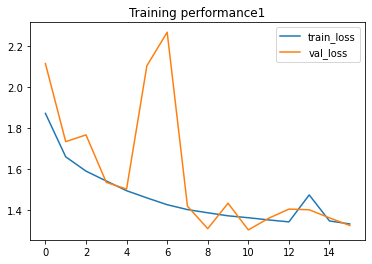

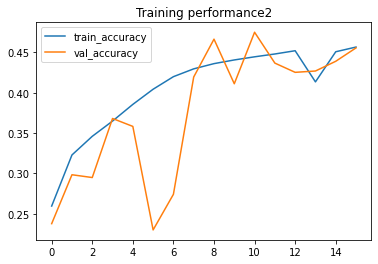

In [ ]:
def train_cnn_model(X_train, y_train, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  # Show accuracy curves
  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_cnn_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/CNN_integral.h5', 100)


#Test of CNN

In [ ]:
def test_cnn_model(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_cnn_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_integral.h5', 100)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

#Plots of the accuracy against the SNR 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

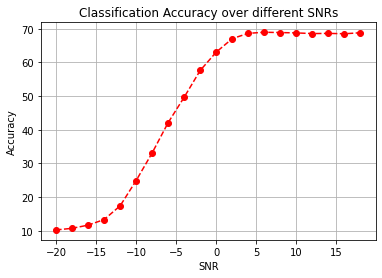

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_integral.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_integral.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_integral.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_integral.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.23,10.7,11.65,13.3,17.38,24.9,33.11,42.13,49.69,57.63,63.07,67.08,68.66,68.98,68.88,68.79,68.58,68.65,68.53,68.83


#confusion matrices and find the most confusing classes

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)            

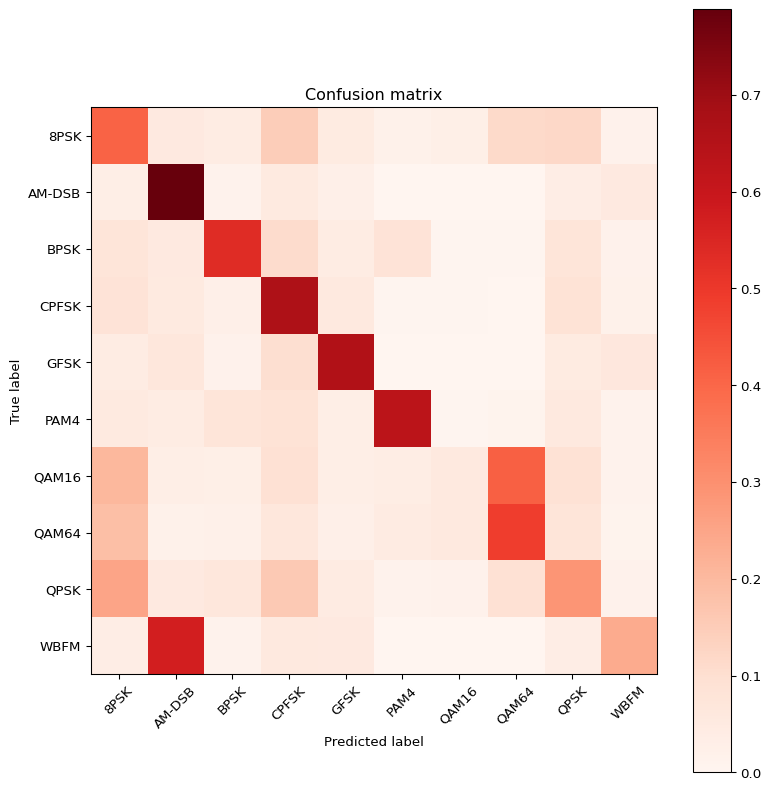

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_integral.h5', 100)


#Model Logistic Regression Classifier

In [9]:
y_train_convert = []
for y in y_train:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_train_convert.append(index_of_maximum)

y_test_convert = []
for y in y_test:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_test_convert.append(index_of_maximum)

In [10]:
from sklearn.linear_model import LogisticRegression
print(X_train.shape)
print(snr_train.shape)
# Create an instance of the scaler and apply it to the data
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

y_train_convert = np.squeeze(y_train_convert) 
y_test_convert = np.squeeze(y_test_convert)
print(y_train_convert.shape)
print(y_test_convert.shape)

LogReg_clf = LogisticRegression()
lrcModel = LogReg_clf.fit(d2_train_dataset, y_train_convert)


y_pred_lrcModel = lrcModel.predict(d2_test_dataset)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_convert, y_pred_lrcModel))
print(confusion_matrix(y_test_convert, y_pred_lrcModel))
print(metrics.classification_report(y_test_convert, y_pred_lrcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

(840000, 2, 128)
(840000,)
(840000,)
(360000,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.1496888888888889
[[ 2374  6778  3575  2245  1847  2200  2079  5006  2296  7469]
 [  448 20307  1260   405   470   408   396  2395   453  9527]
 [ 2378  7367  3841  2544  1711  2467  1853  4124  2699  6918]
 [ 2176  7022  3800  2410  1747  1995  1720  5385  2305  7313]
 [ 1611  7534  5024  1867  1464  1541  1029  6654  1782  7745]
 [ 2265  8774  4279  2818  1456  2592  1558  3615  2913  5730]
 [ 2292  7116  3629  2241  1722  2184  2004  5398  2299  7278]
 [ 2244  7227  3594  2257  1600  2115  2002  5691  2192  6959]
 [ 2305  6770  3583  2367  1894  2324  1953  4893  2407  7417]
 [  632 18105  1875   520   514   540   376  2095   624 10798]]
              precision    recall  f1-score   support

        8PSK       0.13      0.07      0.09     35869
      AM-DSB       0.21      0.56      0.31     36069
        BPSK       0.11      0.11      0.11     35902
       CPFSK       0.12      0.07      0.09     35873
        GFSK       0.10      0.04      0.06     36251
        PAM4   

In [11]:
rows, cols = (360000, 10)
y_pred_lrcModel_convert = [[0 for i in range(cols)] for j in range(rows)] 
for i in range(360000):
  y_pred_lrcModel_convert[i][y_pred_lrcModel[i]] = 1

In [12]:
print(y_pred_lrcModel_convert[0:5])
print(y_pred_lrcModel_convert[0][0])
print(y_pred_lrcModel[0:5])
y_pred_lrcModel_convert = np.array(y_pred_lrcModel_convert)
print(y_pred_lrcModel_convert.shape)

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
0
[5 1 2 3 9]
(360000, 10)


#Evaluation

In [13]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.06618529 0.1889654  0.09966824 0.06258887 0.05149293 0.0613343
  0.05796091 0.13956341 0.06401071 0.20822995]
 [0.01242064 0.56300424 0.03493304 0.01122848 0.01303058 0.01131165
  0.01097896 0.06640051 0.01255926 0.26413263]
 [0.06623586 0.20519748 0.10698568 0.07085956 0.04765751 0.06871483
  0.05161272 0.11486825 0.07517687 0.19269121]
 [0.06065843 0.1957461  0.10592925 0.06718145 0.04869958 0.05561286
  0.04794692 0.1501129  0.06425445 0.20385805]
 [0.04444015 0.20782875 0.13858928 0.05150203 0.04038509 0.04250917
  0.02838542 0.18355356 0.04915726 0.21364928]
 [0.06291667 0.24372222 0.11886111 0.07827778 0.04044444 0.072
  0.04327778 0.10041667 0.08091667 0.15916667]
 [0.0633797  0.19677571 0.10035119 0.06196942 0.04761773 0.06039322
  0.05541576 0.14926859 0.06357327 0.20125543]
 [0.06254006 0.20141579 0.10016443 0.06290237 0.04459185 0.05894485
  0.05579555 0.15860762 0.06109083 0.19394666]
 [0.06418289 0.18851112 0.09976889 0.06590928 0.05273856 0.06471194
  0.05438142 0.136

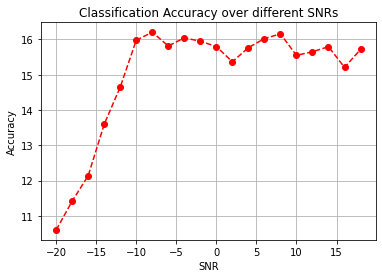

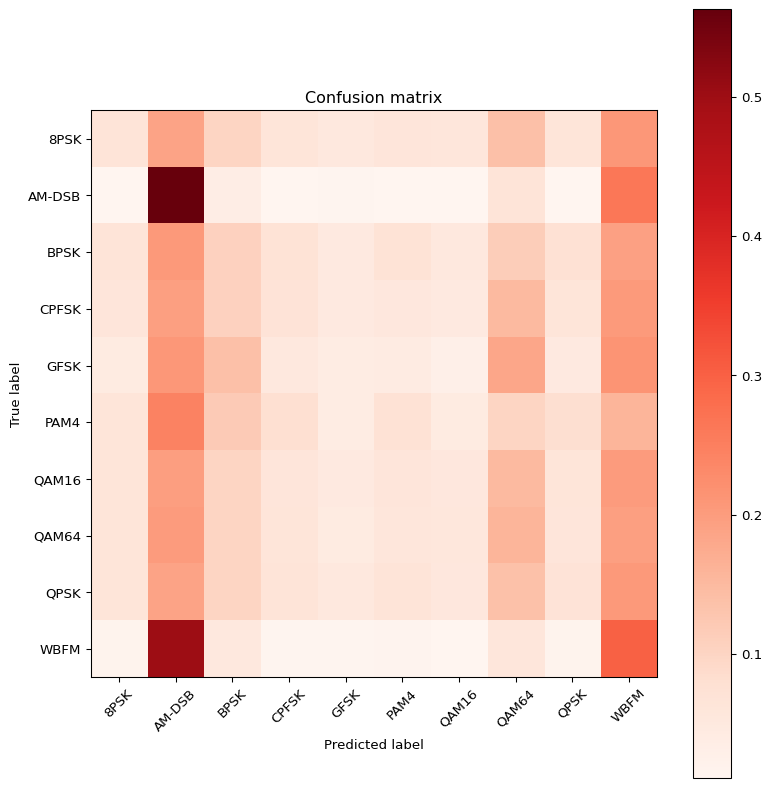

In [ ]:
plot_results(y_pred_lrcModel_convert, y_test, snr_test)

conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_lrcModel_convert[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [14]:
print_results(y_pred_lrcModel_convert, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.61,11.42,12.14,13.6,14.65,15.97,16.2,15.81,16.04,15.95,15.8,15.36,15.76,16.02,16.15,15.55,15.65,15.79,15.21,15.71


#Model Decision Tree 

In [15]:
decisionTreeClassifier = DecisionTreeClassifier()
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
decisionTreeClassifier.fit(d2_train_dataset, y_train)

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))
y_pred_dtcModel = decisionTreeClassifier.predict(d2_test_dataset)


In [16]:
# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtcModel))
print(confusion_matrix(y_test.argmax(axis=1), y_pred_dtcModel.argmax(axis=1)))
print(metrics.classification_report(y_test, y_pred_dtcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

Accuracy: 0.2596777777777778
[[ 4992  1350  3057  4395  2833  2955  4889  5026  4878  1494]
 [ 1417 15397  1182  1341  1698  1087  1245  1328  1309 10065]
 [ 3238  1168  9913  2707  1838  6371  3083  3056  3292  1236]
 [ 4384  1276  2628  7494  3540  2433  4140  4275  4313  1390]
 [ 2762  1606  1679  3661 14134  1771  2669  2655  2712  2602]
 [ 2949  1135  6586  2525  1680 10890  3077  2995  2956  1207]
 [ 4839  1287  2916  4298  2761  2961  5390  5537  4751  1423]
 [ 4849  1137  2801  4337  2722  2831  5255  5733  4864  1352]
 [ 4840  1304  3415  4547  2796  2868  4702  4863  5097  1481]
 [ 1498  9496  1162  1523  2685  1083  1448  1323  1417 14444]]
              precision    recall  f1-score   support

        8PSK       0.14      0.14      0.14     35869
      AM-DSB       0.44      0.43      0.43     36069
        BPSK       0.28      0.28      0.28     35902
       CPFSK       0.20      0.21      0.21     35873
        GFSK       0.39      0.39      0.39     36251
        PAM4   

#Evaluation

[[0.1391731  0.03763696 0.0852268  0.1225292  0.07898185 0.08238312
  0.13630154 0.140121   0.13599487 0.04165157]
 [0.03928581 0.42687626 0.03277052 0.03717874 0.04707644 0.03013668
  0.03451718 0.03681832 0.03629155 0.27904849]
 [0.09018996 0.03253301 0.27611275 0.0753997  0.05119492 0.17745529
  0.08587265 0.08512061 0.09169406 0.03442705]
 [0.1222089  0.03556993 0.07325844 0.20890363 0.09868146 0.0678226
  0.11540713 0.11917041 0.1202297  0.0387478 ]
 [0.076191   0.04430223 0.04631596 0.10099032 0.38989269 0.04885382
  0.07362556 0.07323936 0.07481173 0.07177733]
 [0.08191667 0.03152778 0.18294444 0.07013889 0.04666667 0.3025
  0.08547222 0.08319444 0.08211111 0.03352778]
 [0.1338108  0.03558886 0.0806349  0.11885076 0.07634875 0.08187927
  0.14904737 0.1531123  0.13137737 0.03934961]
 [0.13514116 0.03168808 0.0780636  0.12087177 0.07586188 0.0788997
  0.14645634 0.15977816 0.13555921 0.03768011]
 [0.13477014 0.03630997 0.09509091 0.12661153 0.07785482 0.07985966
  0.13092752 0.135

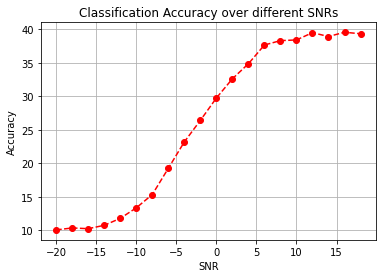

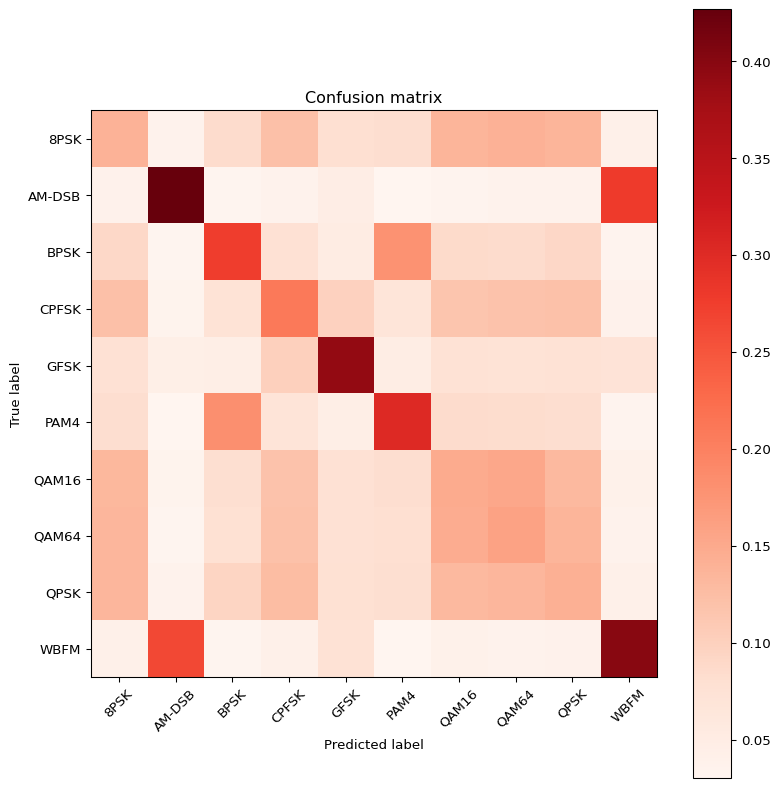

In [17]:
plot_results(y_pred_dtcModel, y_test, snr_test)
print_results(y_pred_dtcModel, y_test, snr_test)
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_dtcModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

#Model Random Forest

In [ ]:
X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs = 1)
nsamples, nx, ny = data[train_examples].shape
#d2_train_dataset = data[train_examples].reshape((nsamples,nx*ny))
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(data[train_examples].reshape((nsamples,nx*ny)), LB().fit_transform(labels[train_examples][:,0]))

nsamples, nx, ny = data[test_examples].shape
#d2_test_dataset = data[test_examples].reshape((nsamples,nx*ny))
y_pred_mrfModel = clf.predict(data[test_examples].reshape((nsamples,nx*ny)))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel))
print(confusion_matrix(LB().fit_transform(labels[test_examples][:,0]).argmax(axis=1), y_pred_mrfModel.argmax(axis=1)))
print(metrics.classification_report(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

#Evaluation

In [ ]:
plot_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,data[test_examples].shape[0]):
    # j is first value in list
    j = list(LB().fit_transform(labels[test_examples][:,0])[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_mrfModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
print_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))